In [1]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import myenvvar
from sklearn.cluster import KMeans
import datetime as dt

In [2]:
conn = MySQLdb.Connection(
        host=myenvvar.db_vars['host'],
        user=myenvvar.db_vars['user'],
        passwd=myenvvar.db_vars['password'],
        port=myenvvar.db_vars['port'],
        db=myenvvar.db_vars['db']
        )

In [4]:
q = "SELECT * FROM audio_features"
audio_features_df = pd.read_sql(q, conn)

In [5]:
audio_features_df.shape

(1806, 17)

In [6]:
audio_features_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,total_available_markets,popularity,added_datetime
0,00bOhb4584JjyfTiXX81mO,0.629,0.387,10,-13.667,1,0.0386,0.42400,0.0000,0.0479,0.497,76.003,275640,4,79,58,2020-06-06 16:50:49
1,00FldKRY0RvsKorwsMzNt3,0.605,0.856,2,-6.094,0,0.0666,0.03460,0.8730,0.0874,0.215,152.005,202105,4,79,37,2020-06-06 16:50:49
2,00HqKJWFv3GS9cPfEB1WQm,0.678,0.795,4,-6.309,0,0.1310,0.01010,0.0159,0.0981,0.648,118.006,215593,4,79,55,2020-06-10 08:09:43
3,00VpefDueq3OB9zkZHLDVI,0.636,0.963,7,-7.309,1,0.0636,0.00342,0.1940,0.1130,0.766,124.971,216025,4,2,26,2020-06-08 07:47:57
4,013vhwBqoO9GHoKhsviiyG,0.530,0.121,1,-11.614,1,0.0481,0.69900,0.9340,0.1010,0.433,79.999,110236,3,79,53,2020-06-06 16:50:49


In [7]:
audio_features_df.set_index('track_id',inplace=True)

In [8]:
cols_to_drop = ['added_datetime']
audio_features_df.drop(cols_to_drop,axis=1,inplace=True)
audio_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,total_available_markets,popularity
track_id,,,,,,,,,,,,,,,
00bOhb4584JjyfTiXX81mO,0.629,0.387,10,-13.667,1,0.0386,0.42400,0.0000,0.0479,0.497,76.003,275640,4,79,58
00FldKRY0RvsKorwsMzNt3,0.605,0.856,2,-6.094,0,0.0666,0.03460,0.8730,0.0874,0.215,152.005,202105,4,79,37
00HqKJWFv3GS9cPfEB1WQm,0.678,0.795,4,-6.309,0,0.1310,0.01010,0.0159,0.0981,0.648,118.006,215593,4,79,55
00VpefDueq3OB9zkZHLDVI,0.636,0.963,7,-7.309,1,0.0636,0.00342,0.1940,0.1130,0.766,124.971,216025,4,2,26
013vhwBqoO9GHoKhsviiyG,0.530,0.121,1,-11.614,1,0.0481,0.69900,0.9340,0.1010,0.433,79.999,110236,3,79,53


# Distributions of tracks audio feaures

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BF98406E88>,
      dtype=object)

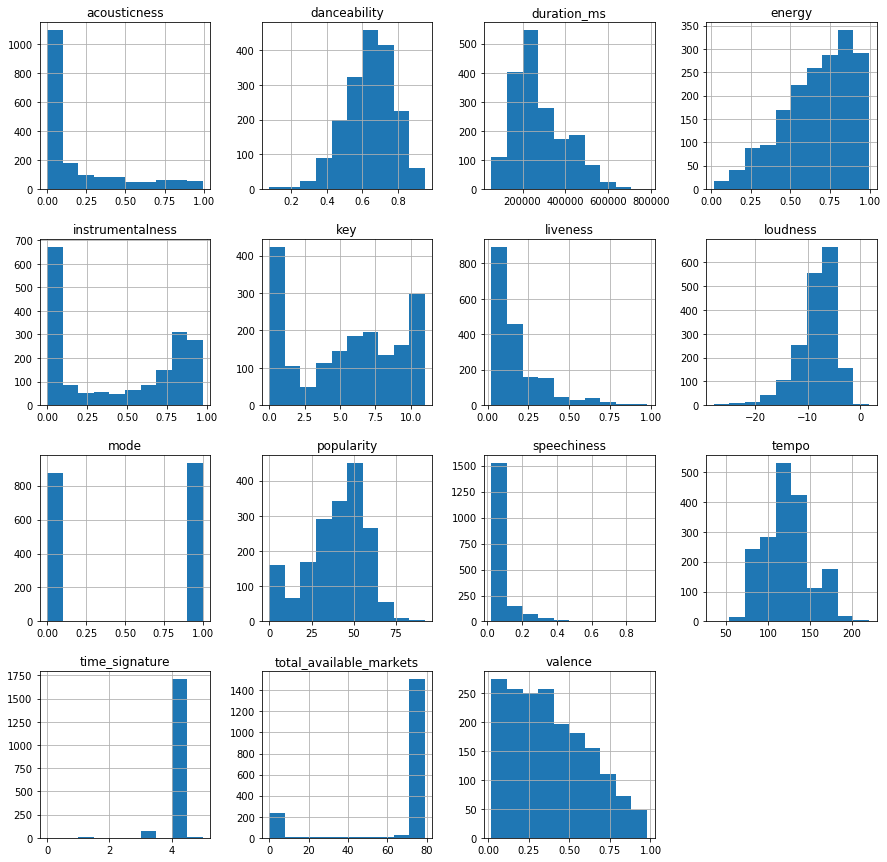

In [13]:
audio_features_df.hist(figsize=(15,15))

## Through observing the distribution plot, we can immediately observe the following:
- There is a very heavy slope downwards in the features speechiness and acousticness, which we can note a slight up-tail in the distribution near the end of the plot. **This indicates to us that the music styles of the tracks are in general less acoustic or speechy**. The uptail indicates to us, that songs with high speechy or acoustic are more likely to be selected near the upper-bound.
- Most of the tracks are not very **lively**, and as the **liveliness** of the track increases, the likelihood of it being featured in the DB decreases.
- **Danceability appears to normally distributed** with tails of the distribution featuring lower likelihoods of being featured in the DB.

# What are the tracks that apply for the min & man of each feature? 

In [16]:
tracks_ids_list = list(audio_features_df.index.values)
tracks_ids_list[:3]

['00bOhb4584JjyfTiXX81mO', '00FldKRY0RvsKorwsMzNt3', '00HqKJWFv3GS9cPfEB1WQm']

### 1. acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 

In [22]:
acousticness_list = list(audio_features_df['acousticness'])
# min
min_index = np.argmin(acousticness_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(acousticness_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:32V75XycGC7MUCkQ6se7iv
max: spotify:track:17OeUFNPrEdOwyuuFGq6Na


min: The track is 'trance' type

max: The track is very 'chill' type with a lot of musical instruments

### 2. danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

In [23]:
danceability_list = list(audio_features_df['danceability'])
# min
min_index = np.argmin(danceability_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(danceability_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:3daicJ3FTsqzXFxMNJ6zXe
max: spotify:track:6rGBks2LevDjAMo5KJq88Y


min: The track very 'chill', not many sounds, no beat

max: The track is very 'monotonic-techno', german style, not so fast not so slow

### 3. duration_ms

In [25]:
duration_ms_list = list(audio_features_df['duration_ms'])
# min
min_index = np.argmin(duration_ms_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(duration_ms_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:3fimYwkWOq8YoXnpRrmyU6
max: spotify:track:0gFQ0zR40UTHeRCg02cJMK


### 4. energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

In [26]:
energy_list = list(audio_features_df['energy'])
# min
min_index = np.argmin(energy_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(energy_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:3sftoMHsX3sCIwIhvYXBov
max: spotify:track:2yss0n7KmvmSr4EHvjfFpn


min: The track very 'meditative-chill-sounds', perfect for relaxation and lowering the energy 

max: The track is very 'hard-rock', energyzing, angry, screaming, motivating

### 5. instrumentalness
Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. **The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content**. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 

In [27]:
instrumentalness_list = list(audio_features_df['instrumentalness'])
# min
min_index = np.argmin(instrumentalness_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(instrumentalness_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:00bOhb4584JjyfTiXX81mO
max: spotify:track:3fimYwkWOq8YoXnpRrmyU6


min: The track very 'church-black-deep-voice', lots of instruments, quite chill 

max: The track is very 'movie-background/chill clothing store', has a live **white-screen television noise** in the background, short track

### 6. key
The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

In [28]:
key_list = list(audio_features_df['key'])
# min
min_index = np.argmin(key_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(key_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:02HlNztgEFU65Nfp64N0lh
max: spotify:track:02X4USIaAlOqV8W3XR7nIo


min: The track very 'dub-reggae', no words almost- a lot of bass and low sounds

max: The track is very high octave, high end sounds. - amharit language

### 7. liveness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

In [29]:
liveness_list = list(audio_features_df['liveness'])
# min
min_index = np.argmin(liveness_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(liveness_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:1mWVesRiDMgR5v7Umv1DBC
max: spotify:track:4bW1aidYiqN0xXxwaXnHKc


min: The track very 'dub-liquid drum and base', doesnt sound live

max: The track is very live - you can here people clapping hands

### 8. loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

In [30]:
loudness_list = list(audio_features_df['loudness'])
# min
min_index = np.argmin(loudness_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(loudness_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:1sDW5dzaHU8cJns5bCin7X
max: spotify:track:6KLcIhlMdXwS5rIFjPbxyg


min: The track very 'meditative-chill', quiet track

max: The track is very 'duft-punky' loud, bass, high-end octave sounds, screaming

### 9. mode
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [31]:
mode_list = list(audio_features_df['mode'])
# min
min_index = np.argmin(mode_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(mode_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:00FldKRY0RvsKorwsMzNt3
max: spotify:track:00bOhb4584JjyfTiXX81mO


min: The track very 'organiky', more of organ

max: The track is very 'pinanowy' more of piano scale

### 10. popularity

### It can be interesting to check what kind of music in more popular on spotify's platform

In [32]:
popularity_list = list(audio_features_df['popularity'])
# min
min_index = np.argmin(popularity_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(popularity_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:0D933CTvEKTkSZSMvAMqrp
max: spotify:track:62aP9fBQKYKxi7PDXwcUAS


min: The track is trance - maybe trance is less popular in spotify's platform?? - worth checking!

max: more a girly song - old mtv

### 11. speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

In [33]:
speechiness_list = list(audio_features_df['speechiness'])
# min
min_index = np.argmin(speechiness_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(speechiness_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:6Ycf7Ch2VlEKlORbz7yfpJ
max: spotify:track:5ZbJR1AfdOsvsYNuCvgqKX


min: The track has words - maybe a mistake

max: very 'wordy' track, kind of rap, words per second very high

### 12. tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

In [34]:
tempo_list = list(audio_features_df['tempo'])
# min
min_index = np.argmin(tempo_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(tempo_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:0zAEIoKDSKzorxOIgo3OOm
max: spotify:track:1wXwO8888WyTeXFBPs3hof


min: The track is very meditative, no structure, no beat

max: track is kind of beaty but I thought it would be more 'electronic' and it is more 'country'..

### 13. time_signature

In [35]:
time_signature_list = list(audio_features_df['time_signature'])
# min
min_index = np.argmin(time_signature_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(time_signature_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:5CNk0kw2Nl9rsLyzzTpv5C
max: spotify:track:0DFjiHjUysH8tAbdwCybFR


### 14. total_available_markets

In [36]:
total_available_markets_list = list(audio_features_df['total_available_markets'])
# min
min_index = np.argmin(total_available_markets_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(total_available_markets_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:0Bw8fmo8dm9tgoQp6yD9qo
max: spotify:track:00bOhb4584JjyfTiXX81mO


### 15. valence
A measure from 0.0 to 1.0 describing the **musical positiveness** conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 

In [37]:
valence_list = list(audio_features_df['valence'])
# min
min_index = np.argmin(valence_list)
print("min:",'spotify:track:' + str(tracks_ids_list[min_index]))
# max
max_index = np.argmax(valence_list)
print("max:",'spotify:track:' + str(tracks_ids_list[max_index]))

min: spotify:track:1r1SmjmtleRUJlZH6m0CAG
max: spotify:track:77INJxJ6rxhiA8plh779AL


min: The track is very dark deep techno, berlin. very gray.

max: track is very happy. half 'selected', funny, good for a funny travel vlog 

# Correlation between features

In [56]:
c = audio_features_df.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
so = so[so != 1] # drop self correlation
so = so[so>0.5] # show features that have a correlation greater than 0.5
so

energy        loudness        0.753948
loudness      energy          0.753948
acousticness  energy          0.689094
energy        acousticness    0.689094
loudness      acousticness    0.580712
acousticness  loudness        0.580712
dtype: float64

- energy and loudness
- acousticness and enerdy
- acousticness and loudness
### energy, loudness and acousticness are highly correlated which makes sense!